<a href="https://colab.research.google.com/github/adarshverma7/five-factor-model/blob/main/Copy_of_Four_clusters_analysis_from_BIG5_Personality_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ocean-five-factor-personality-test-responses:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F679331%2F1193423%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240416%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240416T134428Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da6993bb6340febbd4022471833f923f571d262e8e8416ea47e4c807921cc5227720c536dfe74d59836d3467730d7264f95b3a13dd5ca81ff77372d01058adb28fd96dae23f2c21259e5531d86f0a1ed1c68ae0d838a912df9ffebb1db74505e96bd2600b2e99531918dd77be880352b2a2124379fceb322f04e7366264960430294932ef798404d12c037c5c28110e433d744a1c7b0126fdd2d9bcdc7f8d35a12e310496abaed258095decd0dfa5a755cc5bc68d3fbcfc179a7eef423c55a5eb4754b2312146d5da8796a0a6e165fc01708c274dc7aa96ce7c078539082db7978dd7f1c47587fb106586d695699621201dabe1d883ea459a10d052d10c276be5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 523359 bytes downloaded
Downloaded and uncompressed: ocean-five-factor-personality-test-responses
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sns.set_theme(style="whitegrid", palette="magma")

/kaggle/input/ocean-five-factor-personality-test-responses/data.csv
/kaggle/input/ocean-five-factor-personality-test-responses/codebook.txt


<div style="border-radius: 20px; background-color: #EAE1F4; font-family: Impact; text-align: center; font-size: 34px; color: black; letter-spacing: 2px;">Big Five Personality Test</div>

<center><img src="https://blog.adioma.com/wp-content/uploads/2018/11/big-five-personality-traits-infographic.png" width=500</center>

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">EDA and Data Preprocessing</h1></div>

In [ ]:
df = pd.read_csv('/kaggle/input/ocean-five-factor-personality-test-responses/data.csv', sep='\t')

df.tail()

race  age  engnat  gender  hand  source country  E1  E2  E3  ...  O1  \
19714    11   15       1       2     1       2      SG   1   4   3  ...   1   
19715     3   37       1       2     1       2      US   2   3   2  ...   1   
19716     5   16       2       1     1       2      US   2   5   4  ...   5   
19717    12   16       1       1     1       5      NG   1   4   2  ...   3   
19718     3   35       1       1     1       1      US   2   3   1  ...   5   

       O2  O3  O4  O5  O6  O7  O8  O9  O10  
19714   3   5   3   4   1   4   2   5    3  
19715   2   3   2   3   3   4   2   3    3  
19716   3   1   3   4   1   1   5   5    5  
19717   2   5   3   4   1   5   3   5    5  
19718   1   5   1   4   1   5   5   5    5  

[5 rows x 57 columns]

In [ ]:
df.columns

Index(['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country', 'E1',
       'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5',
       'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9',
       'O10'],
      dtype='object')

  
    
<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-bottom-left-radius: 20px; border-bottom-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black;">There are 7 columns describing the person taking the test (race, age, engnat (Response to "is English your native language?"), gender, hand, source (how did they came to the test), country) and 50 columns related to questions.<BR>
The questions belong to 5 personality groups (see the image above).<BR>
Participants answered the questions rating them on five points scale (1=Disagree, 3=Neutral, 5=Agree (0=missed)).
  </div>

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Nulls</div>

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px;
            padding-top: 10px; padding-bottom: 10px; color: black;">As we know from the additional information attached to the dataset, some people could have left some questions unanswered. These are indicated by 0s in questions columns.<BR>
Thus, zeros in these columns should be considered by pandas as NaNs for easier nulls handling.</div>

In [ ]:
df.loc[:, 'E1':] = df.loc[:, 'E1':].replace(0, np.nan)

In [ ]:
df['E1'].isna().sum()

1

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df['E1'].isna().sum()

0

In [ ]:
df['E1'].value_counts()

E1
3.0    5495
1.0    4675
2.0    4481
4.0    3590
5.0    1468
Name: count, dtype: int64

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Opposing questions issue</div>

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px;
            padding-top: 10px; padding-bottom: 10px; color: black;">I don't like the fact that some questions are constructed in opposite meaning for the given personality variable. Let me explain what I mean on example of first few questions that are related to Extraversion.<BR><BR>

Let's say I am an absolute unit of an introvert. I am shy and reserved.<BR><BR>

First question is: <i>E1 I am the life of the party</i> -> I will pick 'strongly disagree' and get 1 point.<BR>

Second question is: <i>E2 I don't talk a lot</i> -> I will pick 'strongly agree' and get 5 points.<BR>
    
Third question is: <i>E3 I feel comfortable around people</i> -> I will pick 'strongly disagree' and get 1 point.<BR>

Fourth question is: <i>E4 I keep in the background</i> -> I will pick 'strongly agree' and get 5 points.<BR><BR>

Do you see the pattern?<BR><BR>

Taking all 10 questions, I will score 5 times 1 point and 5 times 5 points = 30 points.<BR><BR>

At the same time, an absolute extravert will have the opposite answers but <B>will also score 30 points</B>. So an introvert and an extrovert will score the same amount of points. How are we supposed to distinguish between these two?<BR><BR>

That's why we have to preprocess the questions data so - continuing the example - an absolute introvert will have a minimum of 10 points and extrovert will have the max possible 50 points for this part of questions.<BR><BR>

In other words, I need to analyse all the question groups and identify those that are constructed in opposite way of the personality variable.</div>





In [ ]:
ext_questions = {'E1':  'I am the life of the party.',
                 'E2':  'I don\'t talk a lot.',
                 'E3':  'I feel comfortable around people.',
                 'E4':  'I keep in the background.',
                 'E5':  'I start conversations.',
                 'E6':  'I have little to say.',
                 'E7':  'I talk to a lot of different people at parties.',
                 'E8':  'I don\'t like to draw attention to myself.',
                 'E9':  'I don\'t mind being the center of attention.',
                 'E10': 'I am quiet around strangers.'}

neu_questions = {'N1':  'I get stressed out easily.',  # nervous
                 'N2':  'I am relaxed most of the time.',  # confident
                 'N3':  'I worry about things.',   # nervous
                 'N4':  'I seldom feel blue.',   # confident
                 'N5':  'I am easily disturbed.',   # nervous
                 'N6':  'I get upset easily.',    # nervous
                 'N7':  'I change my mood a lot.',    # nervous
                 'N8':  'I have frequent mood swings.',   # nervous
                 'N9':  'I get irritated easily',   # nervous
                 'N10': 'I often feel blue.'}   # nervous

# measure of one's trusting and helpful nature
agr_questions = {'A1':  'I feel little concern for others.',  # detached
                 'A2':  'I am interested in people.',   # friendly
                 'A3':  'I insult people.',   # detached
                 'A4':  'I sympathize with others feelings.',    # friendly
                 'A5':  'I am not interested in other people problems.',   # detached
                 'A6':  'I have a soft heart',     # friendly
                 'A7':  'I am not really interested in others.',   # detached
                 'A8':  'I take time out for others',    # friendly
                 'A9':  'I feel others emotions',    # friendly
                 'A10': 'I make people feel at ease.'}    # friendly

# tendency to be organized and dependable
con_questions = {'C1': 'I am always prepared.',  # organized
                 'C2': 'I leave my belongings around.',  # careless
                 'C3': 'I pay attention to details', # organized
                 'C4': 'I make a mess of things.',   # careless
                 'C5': 'I get chores done right away.',  # organized
                 'C6': 'I often forget to put things back in their proper place.',   # careless
                 'C7': 'I like order.',  # organized
                 'C8': 'I shirk my duties.',  # careless
                 'C9': 'I follow a schedule.', # organized
                 'C10': 'I am exacting in my work.'}  # organized

# degree of intellectual curiosity, creativity and a preference for novelty
opn_questions = {'O1':  'I have a rich vocabulary.',  # inventive
                 'O2':  'I have difficulty understanding abstract ideas.',  # cautious/consistent
                 'O3':  'I have a vivid imagination.',   # inventive
                 'O4':  'I am not interested in abstract ideas.',   # cautious/consistent
                 'O5':  'I have excellent ideas',  # inventive
                 'O6':  'I do not have a good imagination.',   # cautious/consistent
                 'O7':  'I am quick to understand things.',   # inventive
                 'O8':  'I use difficult words.',    # inventive
                 'O9':  'I spend time reflecting on things.',    # inventive
                 'O10': 'I am full of ideas.'}  # inventive



<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px;
            padding-top: 10px; padding-bottom: 10px; color: black;">After analysis, I picked these questions to be changed to opposite meaning (and the answers will be inverted later):
</div>





In [ ]:
# introvert to extravert
ext_questions['E2'] = 'I talk a lot'
ext_questions['E4'] = "I don't keep in the background."
ext_questions['E6'] = 'I have a lot to say.'
ext_questions['E8'] = 'I like to draw attention to myself.'
ext_questions['E10'] = 'I am not shy around strangers.'

# confident to nervous
neu_questions['N2'] = 'I am stressed most of the time.'
neu_questions['N4'] = 'I often feel blue.'

# detached to friendly
agr_questions['A1'] = 'I feel concern for others.'
agr_questions['A3'] = 'I don\'t insult people.'
agr_questions['A5'] = 'I am interested in other people problems.'
agr_questions['A7'] = 'I am quite interested in others.'

# careless to organized
con_questions['C2'] = 'I don\'t leave my belongings around.'
con_questions['C4'] = 'I don\'t make a mess of things.'
con_questions['C6'] = 'I rarely forget to put things back in their proper place.'
con_questions['C8'] = 'I don\'t shirk my duties.'

# cautious to creative
opn_questions['O2'] = 'I easily understand abstract ideas.'
opn_questions['O4'] = 'I am interested in abstract ideas.'
opn_questions['O6'] = 'I have a good imagination.'

**EDA**

In [ ]:
mid = df.copy()

mid = mid.drop(['race','age','engnat','gender','hand','source','country'],axis = 1)


In [ ]:
mid['Social'] = (mid.E1 + mid.E3 + mid.E5 + mid.E7 + mid.E9)/5
mid.drop(['E1','E3','E5','E7','E9'],axis = 1, inplace = True)

mid['Not_Social'] = (mid.E2 + mid.E4 + mid.E6 + mid.E8 + mid.E10)/5
mid.drop(['E2','E4','E6','E8','E10'],axis = 1, inplace = True)

mid['Optimal_Mood'] = (mid.N2 + mid.N4)/2
mid.drop(['N2','N4'],axis = 1, inplace = True)

mid['Disturbed_Mood'] = (mid.N1 + mid.N3 + mid.N5 +mid.N6+ mid.N7 +mid.N8 + mid.N9 + mid.N10)/8
mid.drop(['N1','N3','N5','N6','N7','N8','N9','N10'],axis = 1, inplace = True)

mid['Positive_social_interactions'] = (mid.A2 + mid.A4 + mid.A6 + mid.A8 + mid.A9 + mid.A10)/6
mid.drop(['A2','A4','A6','A8','A9','A10'],axis = 1, inplace = True)

mid['Negative_Social_Interactions'] = (mid.A1 + mid.A3 + mid.A5 + mid.A7)/4
mid.drop(['A1','A3','A5','A7'],axis = 1, inplace = True)

mid['Organised'] = (mid.C1 + mid.C3 + mid.C5 + mid.C7 + mid.C9 + mid.C10)/6
mid.drop(['C1','C3','C5','C7','C9','C10'],axis = 1, inplace = True)

mid['Unorganised'] = (mid.C2 + mid.C4 + mid.C6 + mid.C8)/4
mid.drop(['C2','C4','C6','C8'],axis = 1, inplace = True)

mid['Thinker'] = (mid.O1 + mid.O3 + mid.O5 + mid.O7 + mid.O8 + mid.O9 + mid.O10)/5
mid.drop(['O1','O3','O5','O7','O8','O9','O10'],axis = 1, inplace = True)

mid['Non_Thinker'] = (mid.O2 + mid.O4 + mid.O6)/3
mid.drop(['O2','O4','O6'],axis = 1, inplace = True)


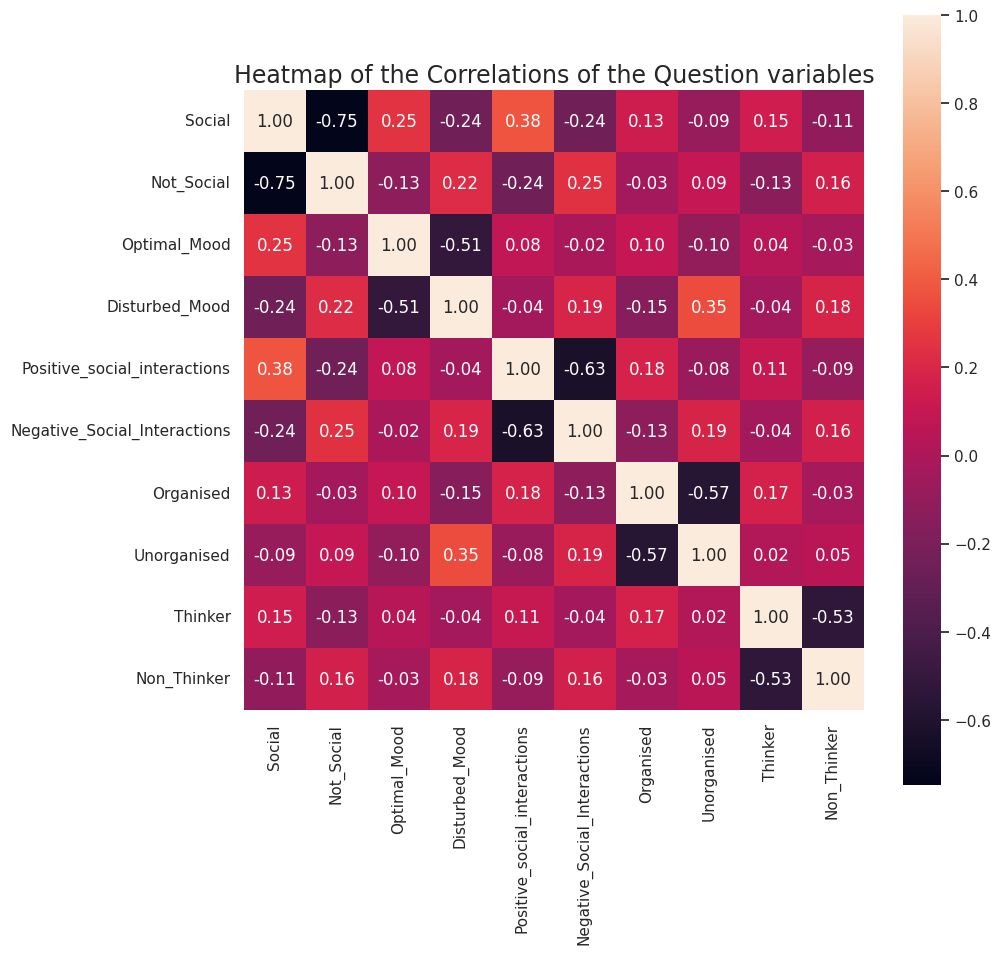

In [ ]:
corr = mid.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, square=True, fmt='.2f', ax=ax)
plt.title('Heatmap of the Correlations of the Question variables', fontsize = 17)
plt.show()





<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px;
            padding-top: 10px; padding-bottom: 10px; color: black;">Now the changed questions will have their answers scale inverted. To achieve this, I will use mapping:
<li> 5 -> -1,
<li> 4 -> -0.5,
<li> 3 -> 0,
<li> 2 -> 0.5,
<li> 1 -> 1
<BR><BR>
After that I will scale the remaining answer points using MinMaxScaler(feature_range=(-1,1)) so all answers are in the same scale.
</div>

In [ ]:
df['E2']

0        2.0
1        2.0
2        1.0
3        5.0
4        1.0
        ... 
19714    4.0
19715    3.0
19716    5.0
19717    4.0
19718    3.0
Name: E2, Length: 19709, dtype: float64

In [ ]:
def invert_and_scale(column):
    df[column].replace(5, -1, inplace=True)
    df[column].replace(4, -0.5, inplace=True)
    df[column].replace(3, 0, inplace=True)
    df[column].replace(2, 0.5, inplace=True)
    df[column].replace(1, 1, inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [ ]:
changed_qs = ['E2', 'E4', 'E6', 'E8', 'E10',
               'N2', 'N4',
               'A1', 'A3', 'A5', 'A7',
               'C2', 'C4', 'C6', 'C8',
               'O2', 'O4', 'O6']

In [ ]:
for col in df.iloc[:, 7:]:
    if col in changed_qs:
        invert_and_scale(col)
    else:
        df[col] = scaler.fit_transform(df[[col]])

In [ ]:
df.iloc[:,7:17]

E1   E2   E3   E4   E5   E6   E7   E8   E9  E10
0      0.5  0.5  1.0  0.5  1.0  1.0  0.5  0.0  1.0  1.0
1     -0.5  0.5  0.0  0.0  0.0  0.0 -1.0 -1.0 -1.0 -1.0
2      1.0  1.0 -1.0 -0.5  1.0  1.0 -1.0 -1.0  1.0  1.0
3     -0.5 -1.0 -0.5 -0.5  0.0 -0.5  0.0 -0.5  0.5 -1.0
4      0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0 -1.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
19714 -1.0 -0.5  0.0 -1.0  0.5  0.0 -1.0  0.5 -1.0 -1.0
19715 -0.5  0.0 -0.5  0.0 -0.5  0.0 -0.5 -0.5  0.5 -0.5
19716 -0.5 -1.0  0.5 -1.0  1.0 -1.0 -1.0  0.5 -1.0 -1.0
19717 -1.0 -0.5 -0.5  0.0 -0.5 -0.5 -1.0  0.0  0.5 -1.0
19718 -0.5  0.0 -1.0 -1.0  0.0  0.0  0.0  0.5 -0.5 -0.5

[19709 rows x 10 columns]

In [ ]:
df[['E2', 'E1']]

E2   E1
0      0.5  0.5
1      0.5 -0.5
2      1.0  1.0
3     -1.0 -0.5
4      1.0  0.0
...    ...  ...
19714 -0.5 -1.0
19715  0.0 -0.5
19716 -1.0 -0.5
19717 -0.5 -1.0
19718  0.0 -0.5

[19709 rows x 2 columns]

In [ ]:
df.describe()

race           age        engnat        gender          hand  \
count  19709.000000  1.970900e+04  19709.000000  19709.000000  19709.000000   
mean       5.322442  5.079277e+04      1.364960      1.616774      1.130194   
std        4.017846  7.123078e+06      0.488753      0.499162      0.413758   
min        0.000000  1.300000e+01      0.000000      0.000000      0.000000   
25%        3.000000  1.800000e+01      1.000000      1.000000      1.000000   
50%        3.000000  2.200000e+01      1.000000      2.000000      1.000000   
75%        8.000000  3.100000e+01      2.000000      2.000000      1.000000   
max       13.000000  1.000000e+09      2.000000      3.000000      3.000000   

             source            E1            E2            E3            E4  \
count  19709.000000  19709.000000  19709.000000  19709.000000  19709.000000   
mean       1.952509     -0.185321      0.120047      0.208483     -0.076031   
std        1.504872      0.616228      0.656847      0.618303      0.611307   
min        1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        1.000000     -0.500000     -0.500000      0.000000     -0.500000   
50%        1.000000      0.000000      0.000000      0.500000      0.000000   
75%        2.000000      0.500000      0.500000      0.500000      0.500000   
max        5.000000      1.000000      1.000000      1.000000      1.000000   

       ...            O1            O2            O3            O4  \
count  ...  19709.000000  19709.000000  19709.000000  19709.000000   
mean   ...      0.346314      0.425136      0.563194      0.460272   
std    ...      0.557937      0.567576      0.503189      0.554878   
min    ...     -1.000000     -1.000000     -1.000000     -1.000000   
25%    ...      0.000000      0.000000      0.500000      0.000000   
50%    ...      0.500000      0.500000      0.500000      0.500000   
75%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

                 O5            O6            O7            O8            O9  \
count  19709.000000  19709.000000  19709.000000  19709.000000  19709.000000   
mean       0.436653      0.602593      0.536633      0.104191      0.566822   
std        0.469631      0.534176      0.461533      0.629363      0.491272   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.000000      0.500000      0.500000     -0.500000      0.500000   
50%        0.500000      1.000000      0.500000      0.000000      0.500000   
75%        1.000000      1.000000      1.000000      0.500000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                O10  
count  19709.000000  
mean       0.502588  
std        0.491627  
min       -1.000000  
25%        0.000000  
50%        0.500000  
75%        1.000000  
max        1.000000  

[8 rows x 56 columns]

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-bottom-left-radius: 20px; border-bottom-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black;">Looks good now.
  </div>

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">Plots</h1></div>

Code from SITI KHOTIJAH great notebook: <a href="https://www.kaggle.com/code/khotijahs1/big-five-personality-test-clustering">[here]</a>.

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Extraversion </div>

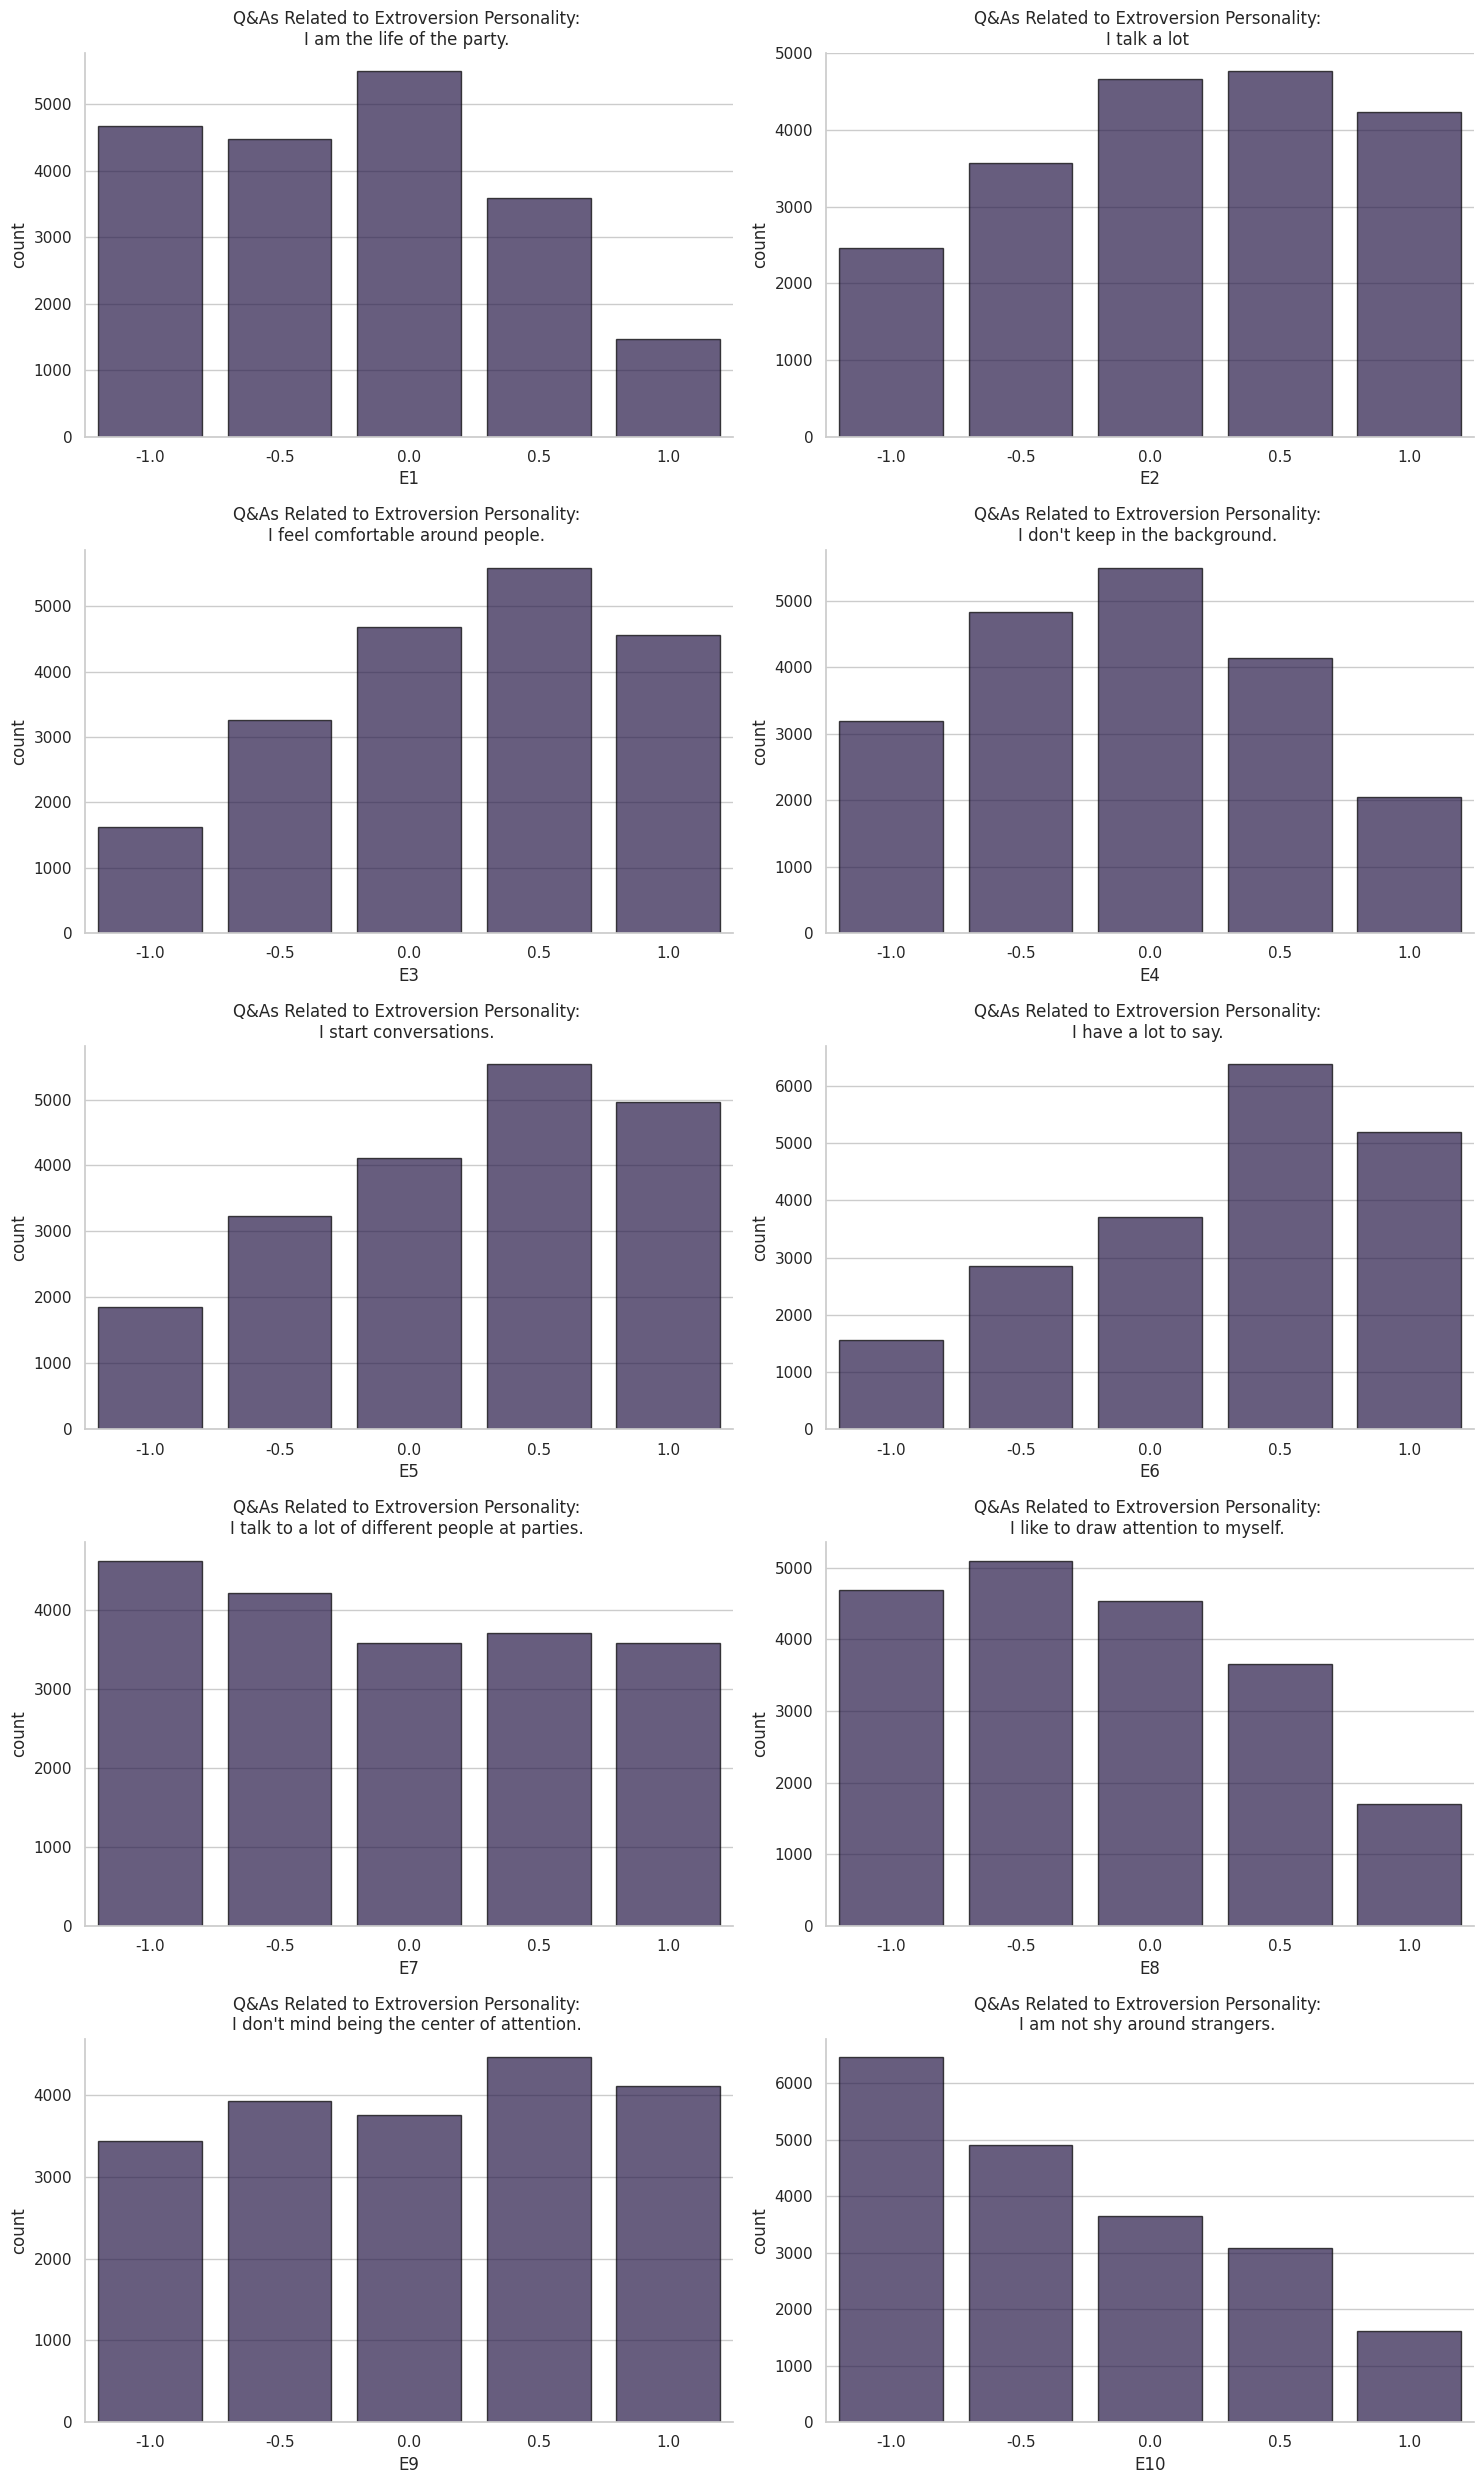

In [ ]:
# barplots showing the frequency of each category
plt.figure(figsize=[15, 25])
questions = ext_questions.keys()
n = 1
for q in questions:
    plt.subplot(5, 2, n)
    sns.countplot(x=q,  edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Q&As Related to Extroversion Personality: \n{} ".format(ext_questions[q]))
    n=n+1
plt.tight_layout()
plt.show()

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Neuroticism</div>

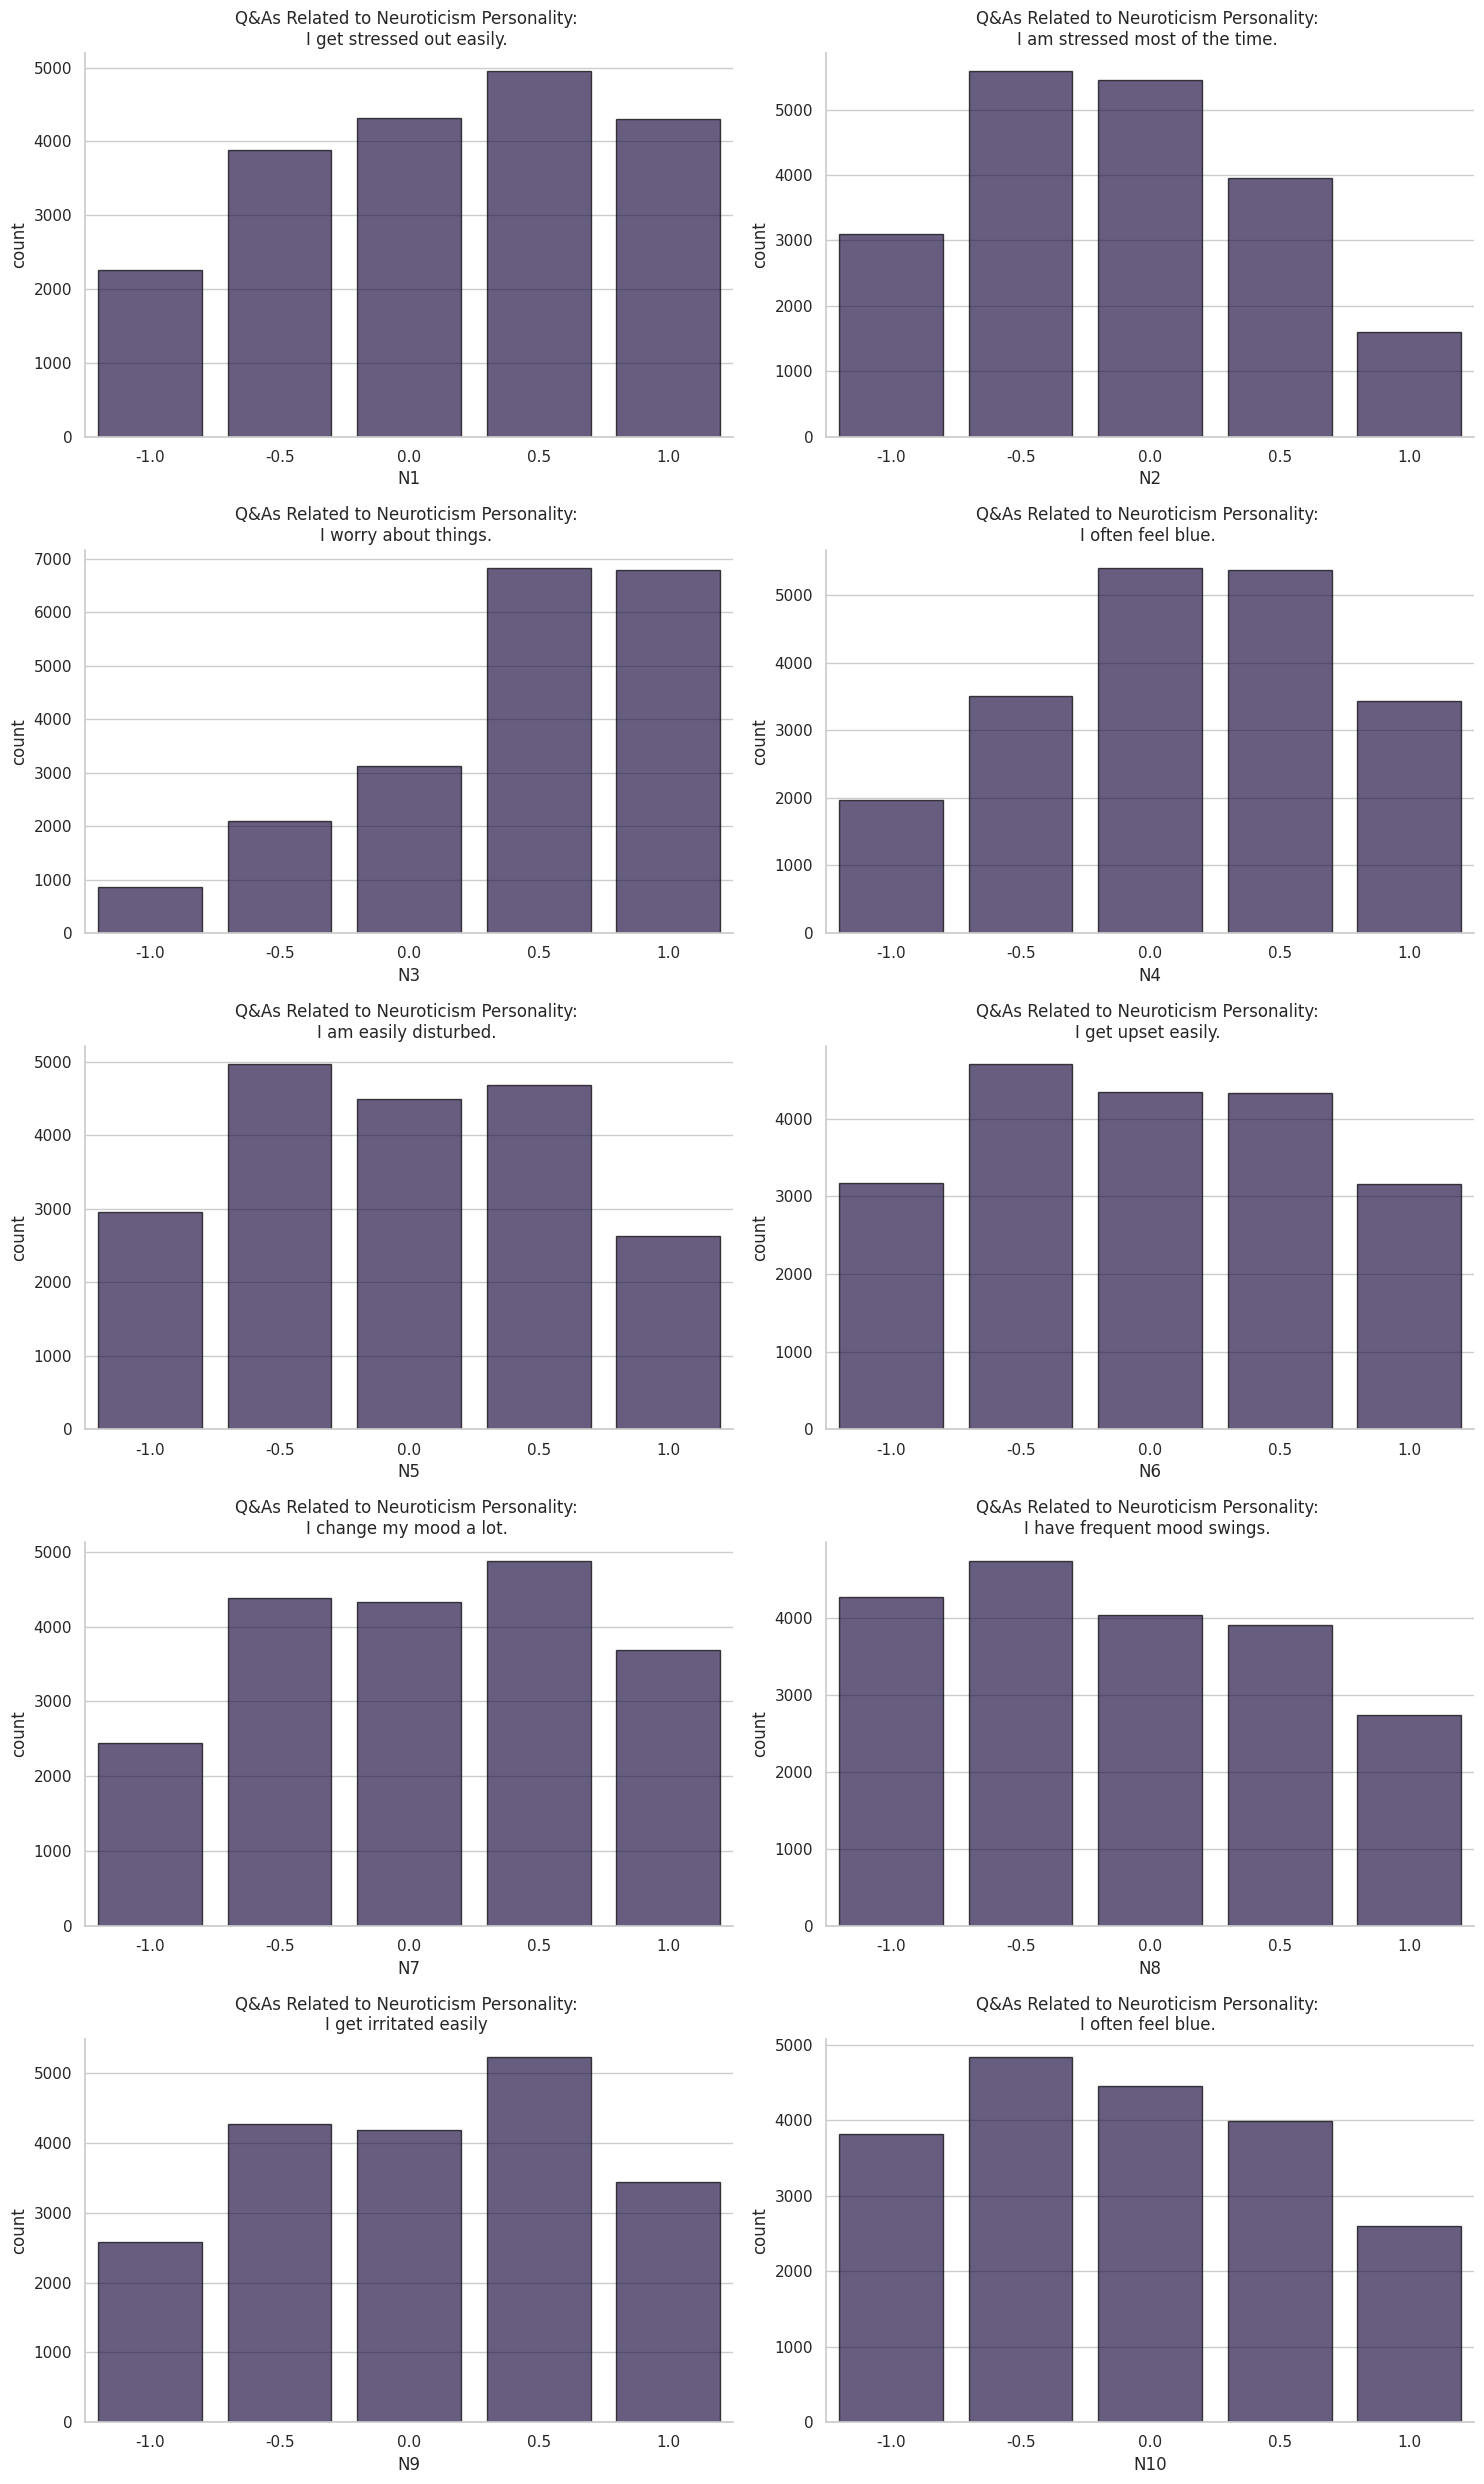

In [ ]:
plt.figure(figsize=[15, 25])
questions = neu_questions.keys()
n = 1
for q in questions:
    plt.subplot(5, 2, n)
    sns.countplot(x=q,  edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Q&As Related to Neuroticism Personality: \n{} ".format(neu_questions[q]))
    n=n+1
plt.tight_layout()
plt.show()

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Agreeableness</div>

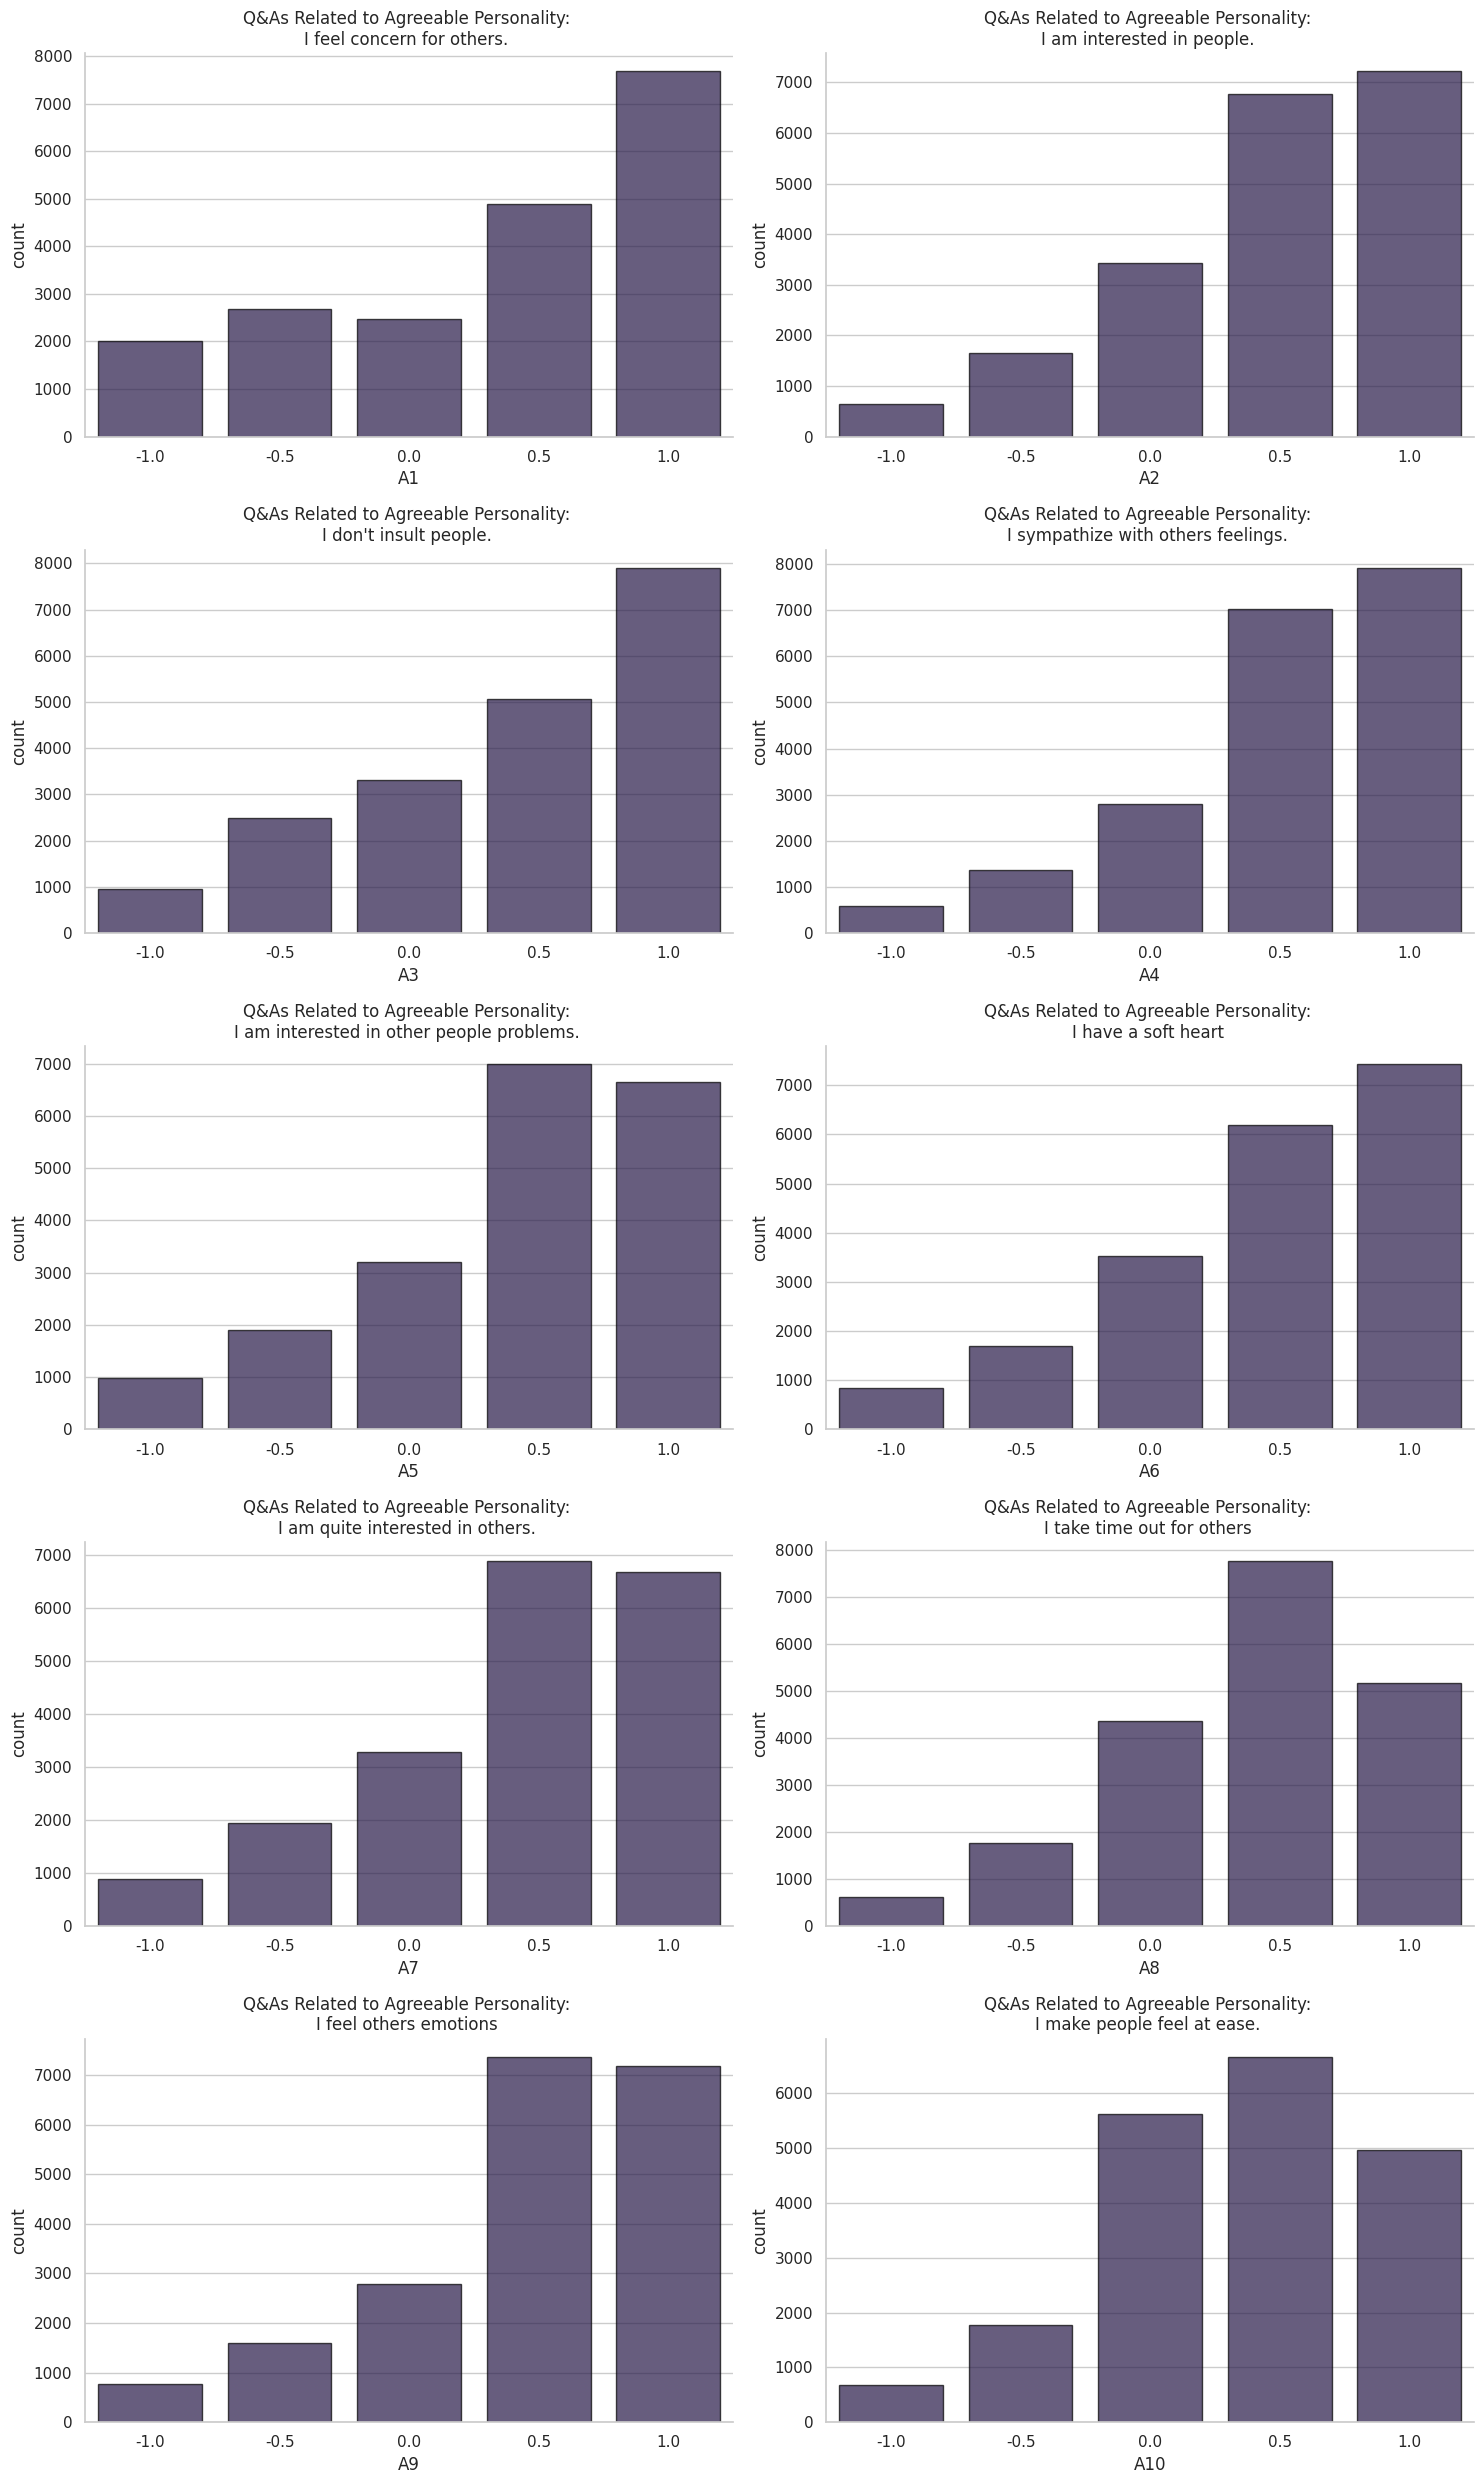

In [ ]:
plt.figure(figsize=[15,25])
questions = agr_questions.keys()
n = 1
for q in questions:
    plt.subplot(5, 2, n)
    sns.countplot(x=q,  edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Q&As Related to Agreeable Personality: \n{} ".format(agr_questions[q]))
    n=n+1
plt.tight_layout()
plt.show()

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Conscientiousness</div>

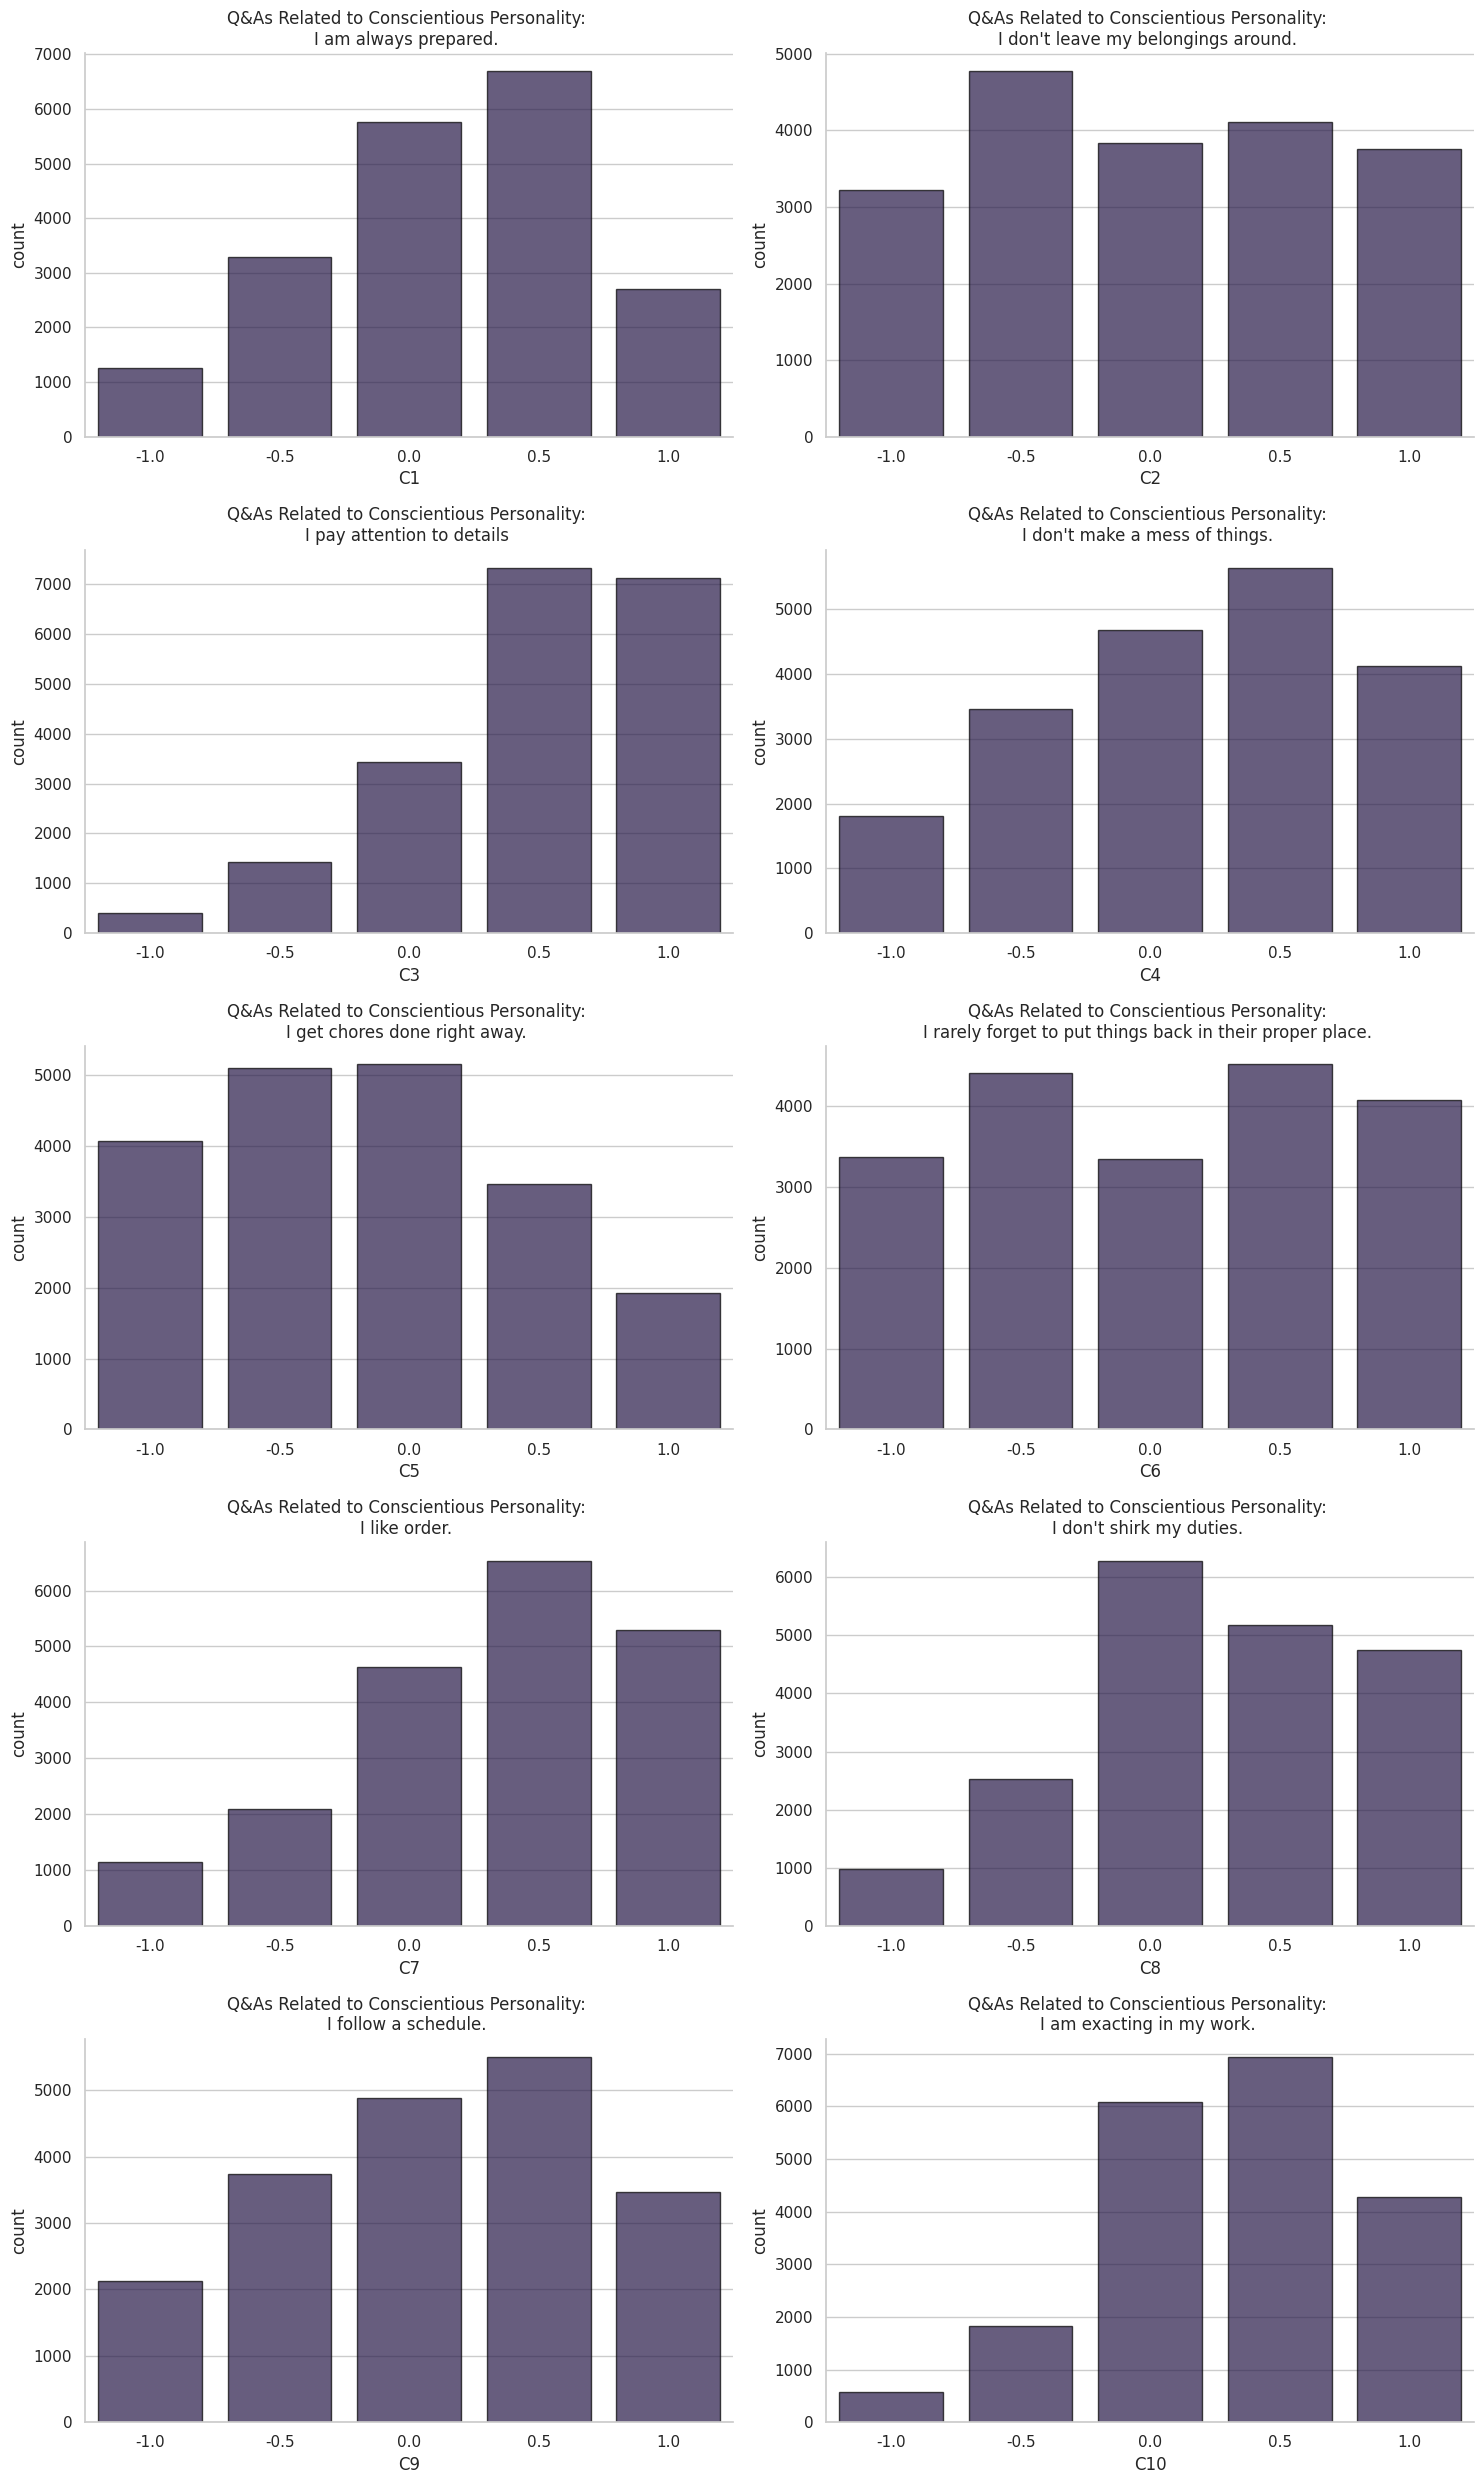

In [ ]:
plt.figure(figsize=[15,25])
questions = con_questions.keys()
n = 1
for q in questions:
    plt.subplot(5, 2, n)
    sns.countplot(x=q,  edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Q&As Related to Conscientious Personality: \n{} ".format(con_questions[q]))
    n=n+1
plt.tight_layout()
plt.show()

<div style="border-top-left-radius: 20px; border-top-right-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; font-weight: bold; font-size: 125%; padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: black;">Openness</div>

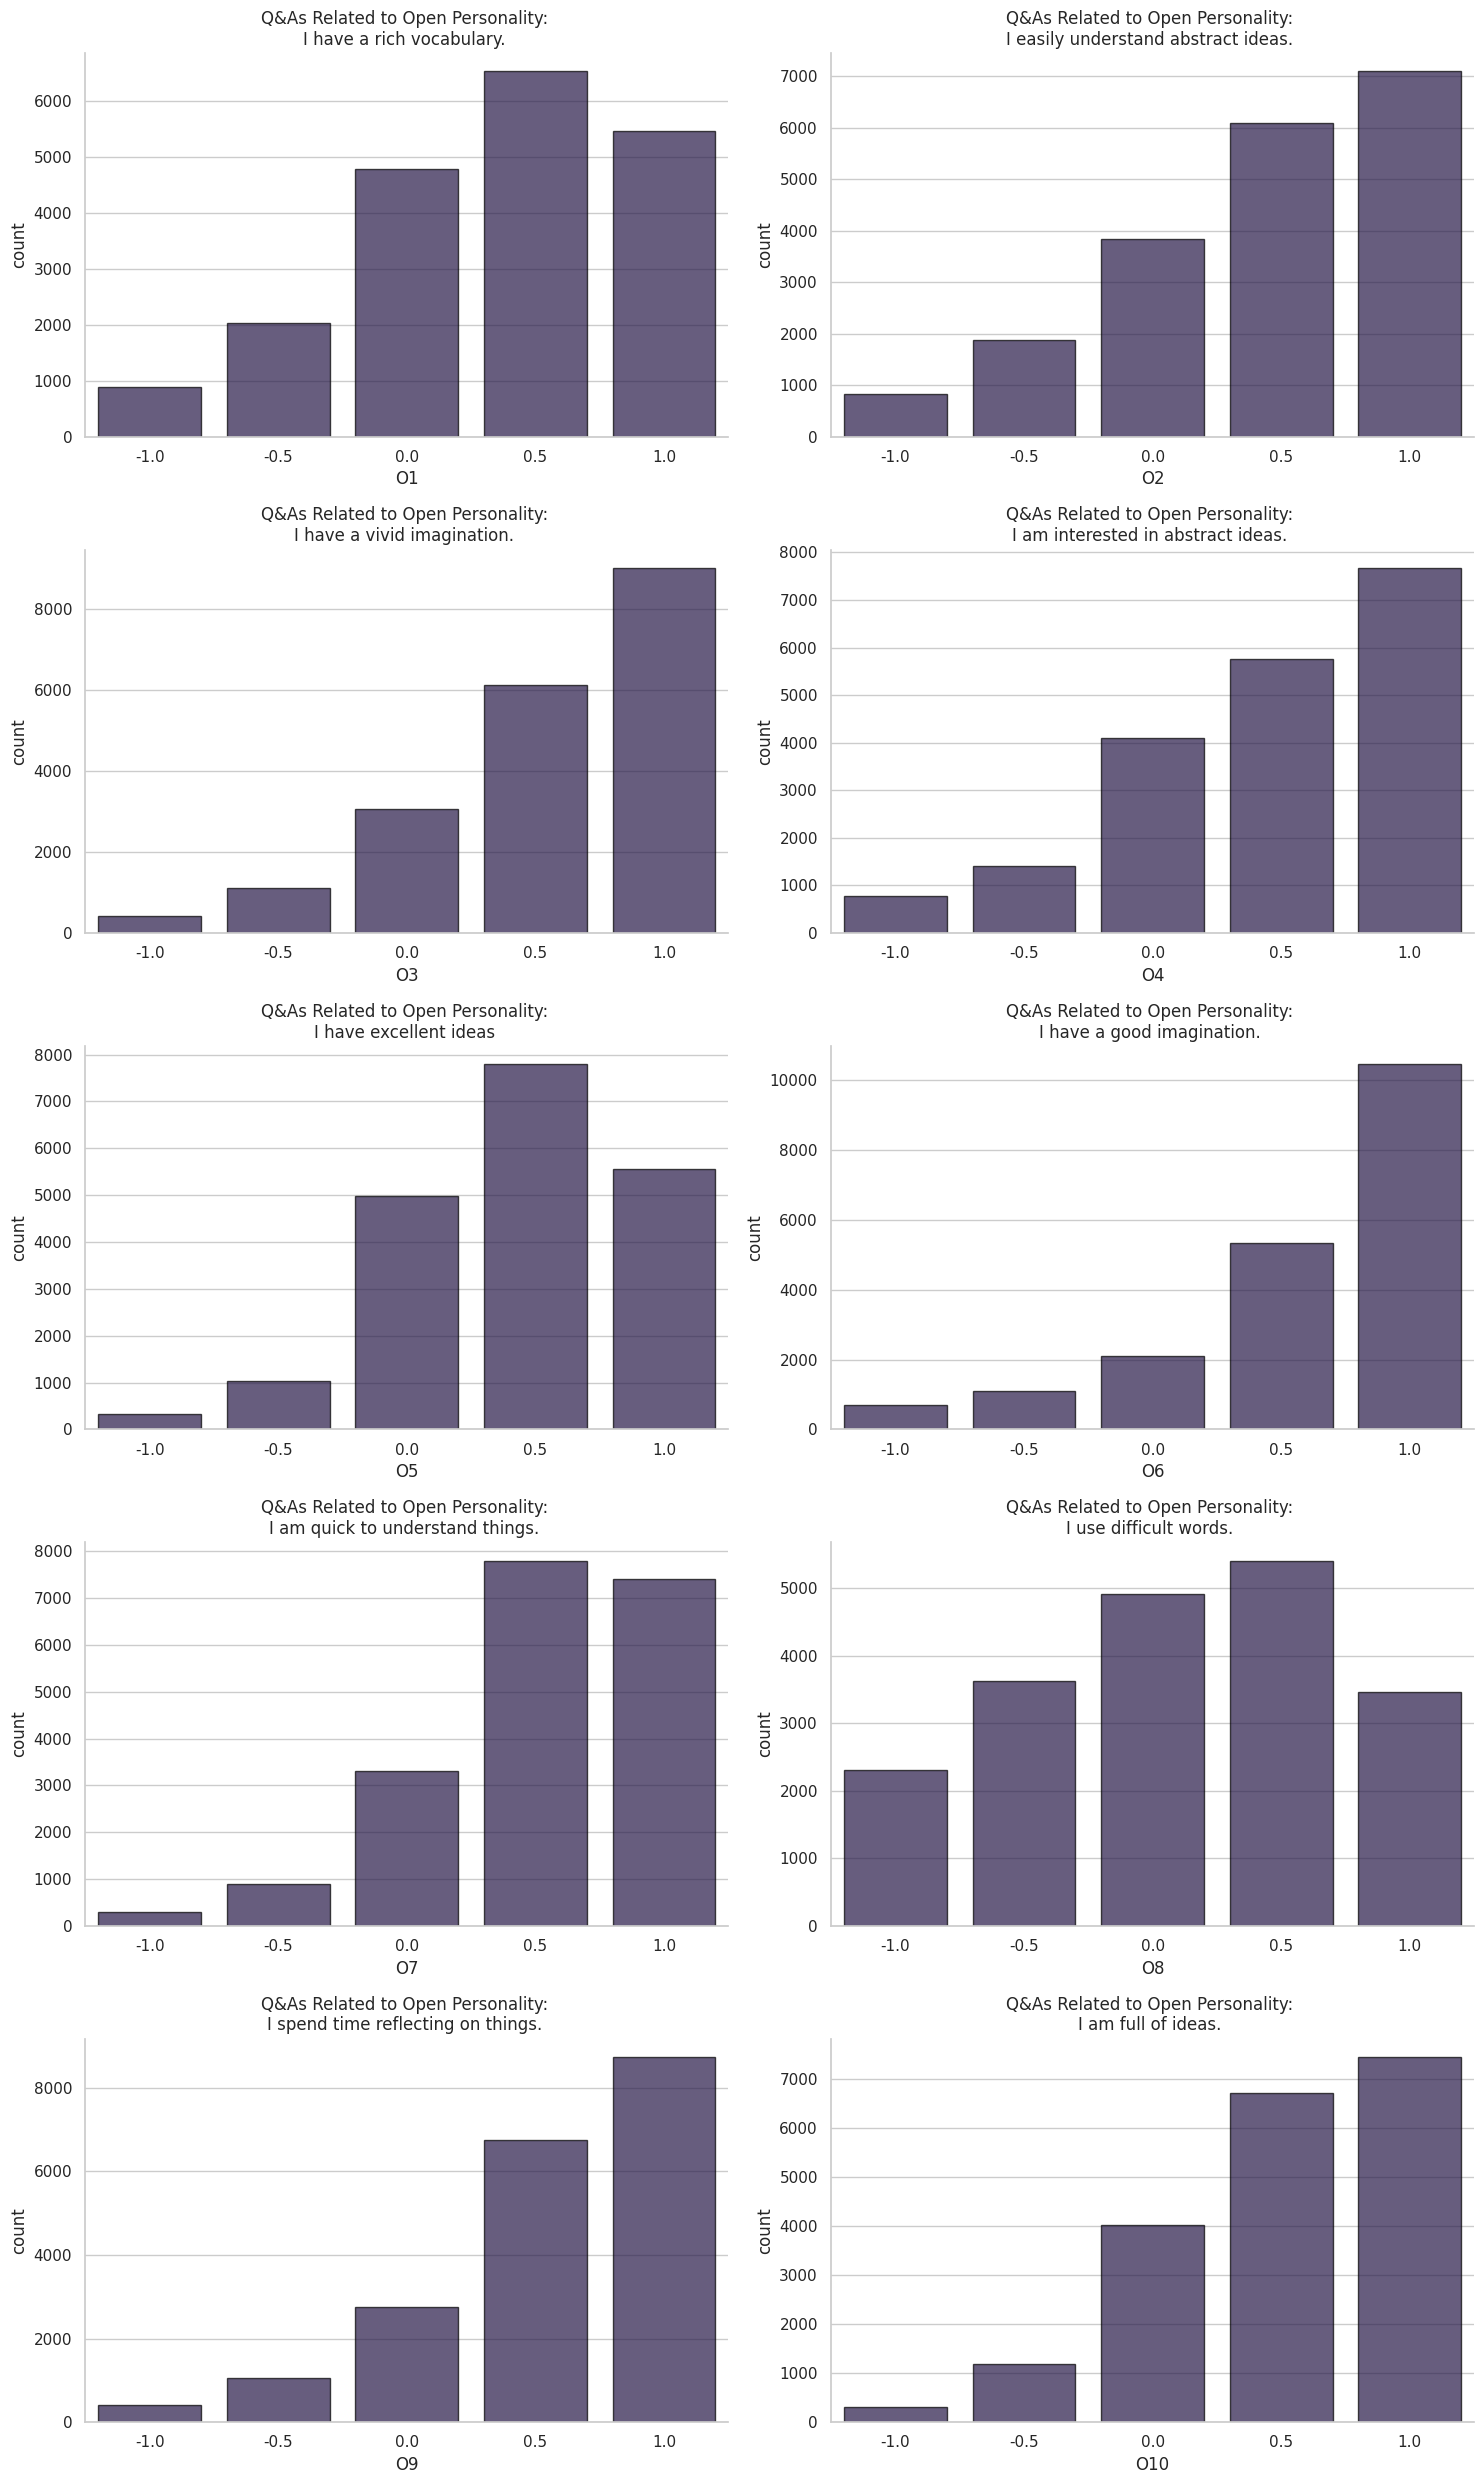

In [ ]:
plt.figure(figsize=[15,25])
questions = opn_questions.keys()
n = 1
for q in questions:
    plt.subplot(5, 2, n)
    sns.countplot(x=q,  edgecolor="black", alpha=0.7, data=df)
    sns.despine()
    plt.title("Q&As Related to Open Personality: \n{} ".format(opn_questions[q]))
    n=n+1
plt.tight_layout()
plt.show()

In [ ]:
df_model = df.drop(['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country'], axis=1)

kmeans = KMeans(n_clusters=5, random_state=42)
k_fit = kmeans.fit(df_model)

In [ ]:
df_model.head()

E1   E2   E3   E4   E5   E6   E7   E8   E9  E10  ...   O1   O2   O3   O4  \
0  0.5  0.5  1.0  0.5  1.0  1.0  0.5  0.0  1.0  1.0  ...  0.5  1.0  0.0  1.0   
1 -0.5  0.5  0.0  0.0  0.0  0.0 -1.0 -1.0 -1.0 -1.0  ...  0.0  0.0  0.0  0.0   
2  1.0  1.0 -1.0 -0.5  1.0  1.0 -1.0 -1.0  1.0  1.0  ...  0.5 -1.0  1.0  1.0   
3 -0.5 -1.0 -0.5 -0.5  0.0 -0.5  0.0 -0.5  0.5 -1.0  ...  0.5  0.0  1.0  0.5   
4  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0 -1.0  ...  0.0  1.0 -1.0  1.0   

    O5   O6   O7   O8   O9  O10  
0  1.0  1.0  0.5 -0.5  1.0  1.0  
1 -0.5  0.0  0.0 -1.0  0.0 -0.5  
2  1.0  1.0  1.0  1.0  1.0  1.0  
3  0.5  0.5  1.0 -0.5  1.0  1.0  
4  0.0  1.0  0.0 -1.0  1.0  0.0  

[5 rows x 50 columns]

In [ ]:
# Predicting the clusters
pd.options.display.max_columns = 10
predictions = k_fit.labels_
df_model['clusters'] = predictions
df_model.head()

E1   E2   E3   E4   E5  ...   O7   O8   O9  O10  clusters
0  0.5  0.5  1.0  0.5  1.0  ...  0.5 -0.5  1.0  1.0         0
1 -0.5  0.5  0.0  0.0  0.0  ...  0.0 -1.0  0.0 -0.5         4
2  1.0  1.0 -1.0 -0.5  1.0  ...  1.0  1.0  1.0  1.0         2
3 -0.5 -1.0 -0.5 -0.5  0.0  ...  1.0 -0.5  1.0  1.0         3
4  0.0  1.0  0.0  0.0  0.0  ...  0.0 -1.0  1.0  0.0         2

[5 rows x 51 columns]

In [ ]:
# within-cluster sum-of-squared
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_model)
    wcss.append(kmeans.inertia_)

wcss = pd.DataFrame(wcss, columns=['wcss'])
wcss = wcss.reset_index()
wcss = wcss.rename(columns={'index': 'clusters'})
wcss['clusters'] += 1
wcss.head()

clusters           wcss
0         1  335342.367901
1         2  312785.274253
2         3  293738.028226
3         4  277650.818155
4         5  273446.937191

In [ ]:
px.line(wcss, x='clusters', y='wcss', width=800, height=500, title='Within-Cluster-Sum of Squared Errors (WCSS)',
        template='ggplot2')

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-bottom-left-radius: 20px; border-bottom-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black;">Looks like the ideal number is 4. And I agree with that, looking at the above PCA plots.</div>

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">4 Clusters with K-Means</h1></div>

In [ ]:
df_model_4 = df.drop(['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country'], axis=1)

kmeans = KMeans(n_clusters=4, random_state=42)
k_fit = kmeans.fit(df_model_4)

predictions = k_fit.labels_
df_model_4['clusters'] = predictions

pca_3 = PCA(n_components=3)
pca_fit = pca_3.fit_transform(df_model_4)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['clusters'] = predictions

px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', template='seaborn',
              title='Personality Clusters after PCA in 3D',
              color='clusters', opacity=0.5, width=650, height=700)

Text(0.5, 1.0, 'Personality Clusters after PCA in 2D')

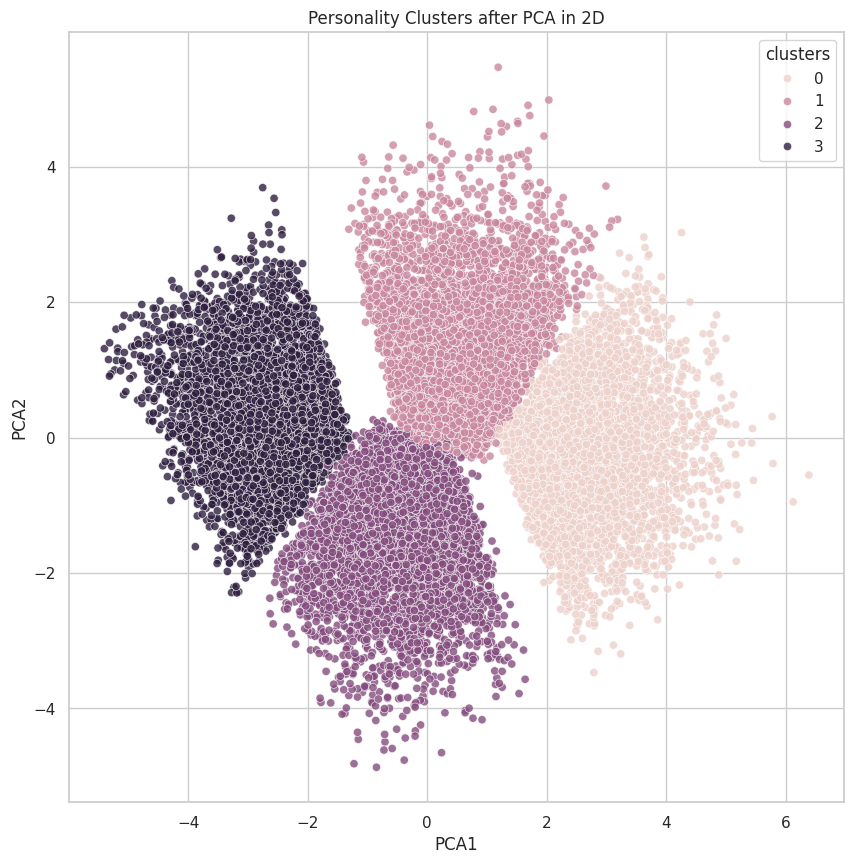

In [ ]:
pca_2 = PCA(n_components=2)
pca_fit = pca_2.fit_transform(df_model_4)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['clusters'] = predictions

plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='clusters', alpha=0.8)
plt.title('Personality Clusters after PCA in 2D')

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-bottom-left-radius: 20px; border-bottom-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black;">This looks nice, doesn't it?<BR><BR>
So here is my proposition that using the Big Five Factor Personality Test, we can distinct 4 types of personalities. I wonder what psychologists say about it (got some reading to do).</div>

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">Feature Engineering</h1></div>

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-top-left-radius: 20px; border-top-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black;">
It is interesting to know the distribution of every question but for statistical conclusion we can actually sum the points per every personality group. This will surely increase calculations performance, as well.
</div>

In [ ]:
df['extraversion_score'] = 0
for x in ext_questions.keys():
    df['extraversion_score'] += df[x]

df['neuroticism_score'] = 0
for x in neu_questions.keys():
    df['neuroticism_score'] += df[x]

df['agreeableness_score'] = 0
for x in agr_questions.keys():
    df['agreeableness_score'] += df[x]

df['conscientiousness_score'] = 0
for x in con_questions.keys():
    df['conscientiousness_score'] += df[x]

df['openness_score'] = 0
for x in opn_questions.keys():
    df['openness_score'] += df[x]

In [ ]:
df.head()

race  age  engnat  gender  hand  ...  extraversion_score neuroticism_score  \
0     3   53       1       1     1  ...                 7.0              -9.5   
1    13   46       1       2     1  ...                -4.0               0.5   
2     1   14       2       2     1  ...                 2.5               8.0   
3     3   19       2       2     1  ...                -4.0               6.5   
4    11   25       2       2     1  ...                 2.0               0.0   

   agreeableness_score  conscientiousness_score  openness_score  
0                  8.0                      8.5             6.5  
1                  2.5                      6.0            -2.0  
2                  4.0                      9.5             7.5  
3                  3.5                     -2.0             5.5  
4                  7.0                      2.0             2.0  

[5 rows x 62 columns]

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">Clustering after FE</h1></div>

In [ ]:
df_model = df[['extraversion_score', 'neuroticism_score', 'agreeableness_score', 'conscientiousness_score', 'openness_score']]

kmeans = KMeans(n_clusters=4, random_state=42)
k_fit = kmeans.fit(df_model)

In [ ]:
# Predicting the clusters
pd.options.display.max_columns = 10
predictions = k_fit.labels_
df_model['clusters'] = predictions
df_model.head()

extraversion_score  neuroticism_score  agreeableness_score  \
0                 7.0               -9.5                  8.0   
1                -4.0                0.5                  2.5   
2                 2.5                8.0                  4.0   
3                -4.0                6.5                  3.5   
4                 2.0                0.0                  7.0   

   conscientiousness_score  openness_score  clusters  
0                      8.5             6.5         1  
1                      6.0            -2.0         2  
2                      9.5             7.5         3  
3                     -2.0             5.5         0  
4                      2.0             2.0         3

In [ ]:
pca_3 = PCA(n_components=3)
pca_fit = pca_3.fit_transform(df_model)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['clusters'] = predictions
df_pca.head()

PCA1      PCA2      PCA3  clusters
0 -13.595151  4.960741 -1.125744         1
1   3.323319  4.630098 -2.409290         2
2  -0.386763 -3.356749 -8.075368         3
3   7.255762 -3.271298 -0.590458         0
4  -2.337558 -1.290722 -0.703492         3

In [ ]:
px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', template='seaborn',
              title='Personality Clusters after PCA in 3D',
              color='clusters', opacity=0.5, width=800, height=700)

In [ ]:
# 2 PCAs

pca_2 = PCA(n_components=2)
pca_fit = pca_2.fit_transform(df_model)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['clusters'] = predictions
df_pca.head()

PCA1      PCA2  clusters
0 -13.595151  4.960741         1
1   3.323319  4.630098         2
2  -0.386763 -3.356749         3
3   7.255762 -3.271298         0
4  -2.337558 -1.290722         3

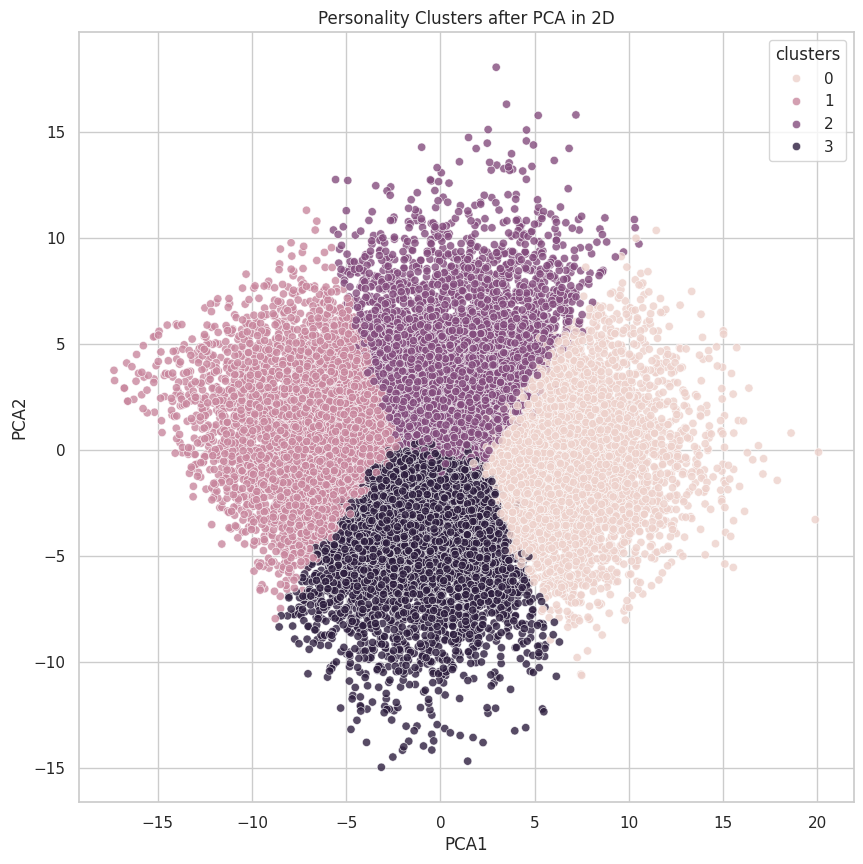

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='clusters', alpha=0.8)
plt.title('Personality Clusters after PCA in 2D');

<div style="background-color: #f9d3ad; font-family: Helvetica; font-size: 110%;
            line-height: 200%; padding-left: 22px; border-bottom-left-radius: 20px; border-bottom-right-radius: 20px;
            padding-top: 10px; padding-bottom: 10px; color: black">
Wow! It's interesting to see that 5 clusters are completely wrong and 4 separate clusters are indeed better. However, this data gives us clusters that are not as well separated as on previous plots.
</div>

# <div style="border-radius: 20px; background-color: #EAE1F4; font-family: Helvetica; letter-spacing: 2px;"><h1 style="padding-left: 22px; padding-top: 10px; padding-bottom: 10px; color: #686676; font-size: 100%;">Summary of the Clusters</h1></div>

In [ ]:
desc = df_model.groupby('clusters')[['extraversion_score', 'neuroticism_score', 'agreeableness_score', 'conscientiousness_score', 'openness_score']].describe()

In [ ]:
desc

extraversion_score                                 ...  \
                      count      mean       std   min  25%  ...   
clusters                                                    ...   
0                    4615.0 -4.667931  2.679262 -10.0 -6.5  ...   
1                    4492.0  4.513691  2.677600  -4.0  2.5  ...   
2                    5203.0 -2.613300  2.748788 -10.0 -4.5  ...   
3                    5399.0  2.961937  2.709623  -3.5  1.0  ...   

         openness_score                       
                    min  25%  50%  75%   max  
clusters                                      
0                 -10.0  1.5  4.0  6.5  10.0  
1                  -7.0  4.0  6.0  7.5  10.0  
2                  -7.5  2.0  4.0  6.5  10.0  
3                  -8.5  3.0  5.0  7.0  10.0  

[4 rows x 40 columns]

In [ ]:
summary = pd.concat(
    objs=(i.set_index('clusters') for i in (
        desc['extraversion_score'][['count', 'mean']].reset_index(),
        desc['neuroticism_score'][['mean']].reset_index(),
        desc['agreeableness_score'][['mean']].reset_index(),
        desc['conscientiousness_score'][['mean']].reset_index(),
        desc['openness_score'][['mean']].reset_index())),
    axis=1,
    join='inner').reset_index()



In [ ]:
summary.columns = ['clusters', 'cluster_count', 'extraversion_mean', 'neuroticism_mean', 'agreeableness_mean', 'conscientiousness_mean', 'openness_mean']

In [ ]:
summary

clusters  cluster_count  extraversion_mean  neuroticism_mean  \
0         0         4615.0          -4.667931          4.637378   
1         1         4492.0           4.513691         -3.825356   
2         2         5203.0          -2.613300         -1.999808   
3         3         5399.0           2.961937          2.916373   

   agreeableness_mean  conscientiousness_mean  openness_mean  
0            2.376490               -0.108884       3.701950  
1            6.436776                3.952916       5.675757  
2            3.007784                2.742841       4.056506  
3            5.129376                0.499815       4.793388

<Figure size 900x700 with 0 Axes>

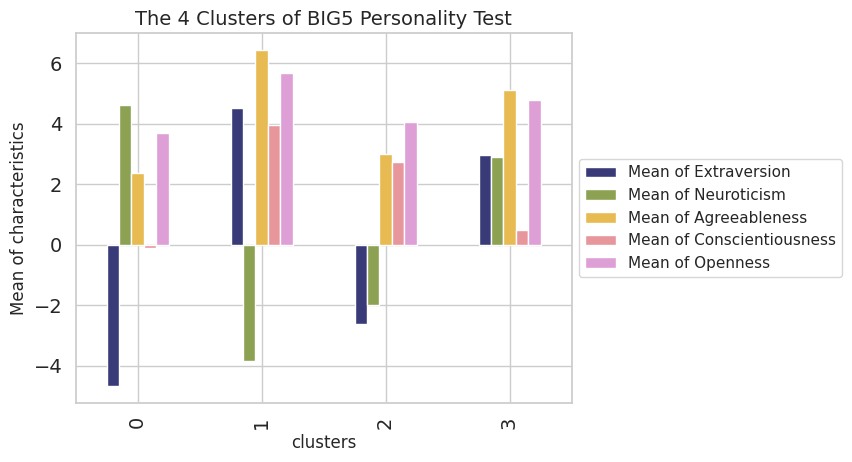

In [ ]:
plt.figure(figsize=(9, 7))
summary.plot(x='clusters',
             y=['extraversion_mean', 'neuroticism_mean', 'agreeableness_mean', 'conscientiousness_mean', 'openness_mean'],
             kind='bar',
             ylabel='Mean of characteristics',
             fontsize=14, cmap="tab20b").legend(loc='center left', bbox_to_anchor=(1, 0.5),
                                                labels=['Mean of Extraversion',
                                                        'Mean of Neuroticism',
                                                        'Mean of Agreeableness',
                                                        'Mean of Conscientiousness',
                                                        'Mean of Openness'])
plt.title('The 4 Clusters of BIG5 Personality Test', fontsize=14)
plt.show()

In [ ]:
my_data1 = pd.read_excel('/content/Personality (Responses).xlsx')
my_data1
my_data2 = my_data1.copy()
my_data2

E1  E2  E3  E4  E5  ...  O6  O7  O8  O9  O10
0   5   5   5   5   5  ...   1   2   2   3    4

[1 rows x 50 columns]

In [ ]:
my_data2['E1']

0    5
Name: E1, dtype: int64

In [ ]:
def invert_and_scale1(column):
    my_data2[column].replace(5, -1, inplace=True)
    my_data2[column].replace(4, -0.5, inplace=True)
    my_data2[column].replace(3, 0, inplace=True)
    my_data2[column].replace(2, 0.5, inplace=True)
    my_data2[column].replace(1, 1, inplace=True)

In [ ]:
for col in my_data1.iloc[:,:]:
    if col in changed_qs:
        invert_and_scale1(col)
    else:
        my_data2[col] = scaler.fit_transform(my_data2[[col]])

In [ ]:
my_data2


E1  E2   E3  E4   E5  ...  O6   O7   O8   O9  O10
0 -1.0  -1 -1.0  -1 -1.0  ...   1 -1.0 -1.0 -1.0 -1.0

[1 rows x 50 columns]

In [ ]:
my_data3 = my_data2.copy()

In [ ]:
my_data3['extraversion_score'] = 0
for x in ext_questions.keys():
    my_data3['extraversion_score'] += my_data2[x]

my_data3['neuroticism_score'] = 0
for x in neu_questions.keys():
    my_data3['neuroticism_score'] += my_data2[x]

my_data3['agreeableness_score'] = 0
for x in agr_questions.keys():
    my_data3['agreeableness_score'] += my_data2[x]

my_data3['conscientiousness_score'] = 0
for x in con_questions.keys():
    my_data3['conscientiousness_score'] += my_data2[x]

my_data3['openness_score'] = 0
for x in opn_questions.keys():
    my_data3['openness_score'] += my_data2[x]

In [ ]:
my_data3

E1  E2   E3  E4   E5  ...  extraversion_score  neuroticism_score  \
0 -1.0  -1 -1.0  -1 -1.0  ...                -7.5              -10.0   

   agreeableness_score  conscientiousness_score  openness_score  
0                 -4.5                     -4.0            -5.0  

[1 rows x 55 columns]

In [ ]:
my_data4 = my_data3[['extraversion_score', 'neuroticism_score', 'agreeableness_score', 'conscientiousness_score', 'openness_score']]
my_data4

extraversion_score  neuroticism_score  agreeableness_score  \
0                -7.5              -10.0                 -4.5   

   conscientiousness_score  openness_score  
0                     -4.0            -5.0

In [ ]:
my_personality = k_fit.predict(my_data4)
print('My Personality Cluster: ', my_personality)

My Personality Cluster:  [2]


<Figure size 1000x700 with 0 Axes>

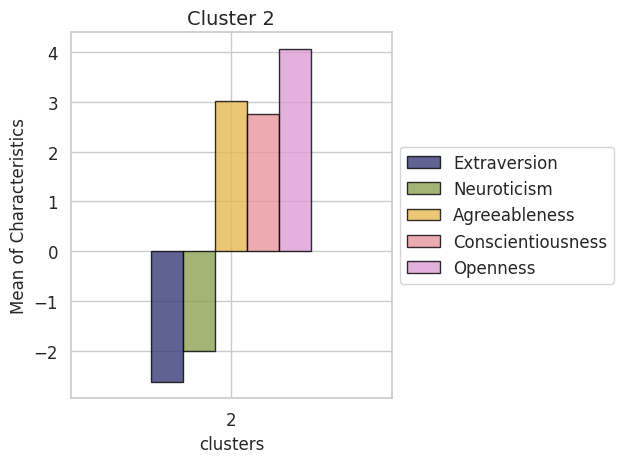

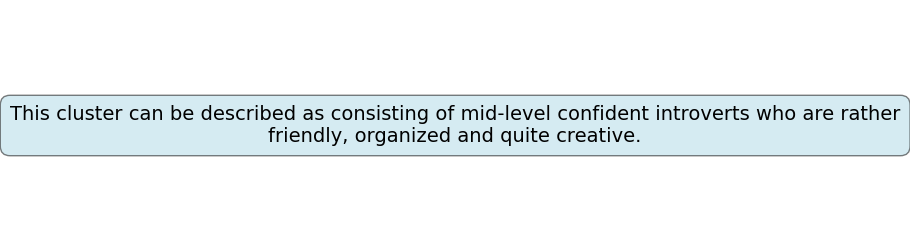

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Filter summary dataframe for the current cluster
cluster_data = summary[summary['clusters'] == my_personality[0]]

# Plot the bar chart for the current cluster
plt.figure(figsize=(10, 7))
cluster_data.plot(x='clusters',
                  y=['extraversion_mean', 'neuroticism_mean', 'agreeableness_mean', 'conscientiousness_mean', 'openness_mean'],
                  kind='bar',
                  ylabel='Mean of Characteristics',
                  fontsize=12,
                  cmap="tab20b",  # Use default colors from tab20b colormap
                  edgecolor='black',           # Add edge color to bars
                  linewidth=1,                 # Set width of edge line
                  alpha=0.8,                   # Adjust transparency of bars
                  rot=0)                       # Rotate x-axis labels

# Add legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           labels=['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness'],
           fontsize=12)

# Set title and adjust font size
plt.title(f'Cluster {my_personality[0]}', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Display description below in a styled box
description = ""
if my_personality[0] == 0:
    description = "This cluster is made of mostly introverted, quite nervous, friendly and creative but neither careless nor organized personalities."
elif my_personality[0] == 1:
    description = "This cluster is made of mostly extroverted, friendly, organized and curious and also very confident people."
elif my_personality[0] == 2:
    description = "This cluster can be described as consisting of mid-level confident introverts who are rather friendly, organized and quite creative."
elif my_personality[0] == 3:
    description = "This cluster consists of mid-level nervous extraverts who are really friendly and creative but neither careless nor organized."

plt.figure(figsize=(10, 3))
bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightblue", alpha=0.5)
plt.text(0.5, 0.5, description, fontsize=14, ha='center', va='center', wrap=True, bbox=bbox_props, color='black')
plt.axis('off')
plt.show()
